### Import Dependncies


In [1]:
from bin_calculator import bin_calculator  # type: ignore
import sys
import numpy as np
import scipy as sc
from scipy import stats
from scipy.stats import norm, skew, kurtosis, probplot
from scipy.integrate import quad
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import datetime as dt
import yfinance as yf
from yahoo_fin import options
import pandas as pd
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings("ignore")

plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
)


sys.path.append(
    r"C:\Users\rrenard\Arkus_python\pricing_library\models\utilities")

# Heston Volatility Model

The heston model is defined as a system of SDEs, used to model the volatility of an underlying asset.

Under real-world probability measure $\mathbb{P}$, the dynamics of the asset price $S_t$ and the variance $v_t$ are given by:

**$$dS_t = \mu S_t dt + \sqrt{v_t}S_tdW^{\mathbb{P}}_{S,t}$$**
**$$dv_t = \kappa(\theta - v_t)dt + \sigma\sqrt{v_t}dW^{\mathbb{P}}_{v,t}$$**
**$$\rho dt = dW^{\mathbb{P}}_{S,t} dW^{\mathbb{P}}_{v,t}$$**

Where:

- $\theta$ is the long-run average variance of the price
- $\kappa$ is the mean reversion speed
- $\sigma$ is the volatility of volatility
- $\rho$ is the correlation between the two Wiener process
- $dW^{\mathbb{P}}_{S,t}$ and $dW^{\mathbb{P}}_{v,t}$ are two correlated Wiener process

Note: 

- To take into account leverage effect, Wiener Stochastic process $dW_{S,t}$ and $dW_{v,t}$ should be correlated $dW_{S,t} \cdot dW_{v,t} = \rho dt$
- The stochastic model for the variance $v_t$ is a CIR (Cox, Ingersoll and Ross) process. For the square-root process, the variance is always positive and if $2 \kappa > \sigma^2$ then it cannot reach 0. 
- The deterministic part of equation 2 is asympotically stable if $\kappa > 0$. Equilibrium point is $v_t = \theta$

Under the risk-neutral probability measure $\mathbb{Q}$, the dynamics of the asset price $S_t$ and the variance $v_t$ are given by:

**$$dS_t = rS_t dt + \sqrt{v_t}S_tdW^{\mathbb{Q}}_{S,t}$$**
**$$dv_t = \kappa^{\mathbb{Q}}(\theta^{\mathbb{Q}} - v_t)dt + \sigma^{\mathbb{Q}}\sqrt{v_t}dW^{\mathbb{Q}}_{v,t}$$**
**$$\rho^{\mathbb{Q}} dt = dW^{\mathbb{Q}}_{S,t} dW^{\mathbb{Q}}_{v,t}$$**

Where:

- $\rho^{\mathbb{Q}} = \rho$, is the correlation parameter
- $\lambda$, is the variance risk premium
- $\kappa^{\mathbb{Q}} = \kappa + \lambda$, is the mean reversion rate/speed
- $\theta^{\mathbb{Q}} = \frac{\kappa\theta}{\kappa + \lambda}$, is the long-run average variance of the price


## Notation

- $S_t$, is the asset price at time $t$
- $v_t$, is the variance at time $t$
- $C$, European call option
- $K$, Strike price
- $W_s , W_v$, Standard brownian motions
- $r$, Risk-free interest rate
- $\kappa$, Mean reversion speed
- $\theta$, Long-run average variance of the price
- $\sigma$, Volatility of volatility
- $\rho$, Correlation parameter
- $t$, Current time
- $T$, Maturity time
- $\tau = T - t$, time spam

# Heston Model - Monte Carlo Simulation

## Euler discretization scheme

- Discretization of the variance process $v_t$:

**$$v_{t + dt} = v_t + \kappa(\theta - v_t) dt + \sigma\sqrt{v_{t}dt}Z_v$$**

Where $Z_v$ is a standard normal random variable - $Z_v \sim \mathcal{N}(0,1)$

To avoid negative variance, we can replace $v_t$ by $\max \{0, v_t\}$, this is the full truncation scheme. The reflection scheme is also possible, where we replace $v_t$ by |$v_t$|.

- Discretization of the asset price process $ ln(S_t)$:

**$$ln(S_{t + dt}) = ln(S_t) + (r - \frac{1}{2} v_t)dt + \sqrt{v_{t}dt}Z_S$$**
**$$S_{t + dt} = S_t \exp((r - \frac{1}{2} v_t)dt + \sqrt{v_{t}dt}Z_S)$$**

Where $Z_S$ is a standard normal random variable ($Z_S \sim \mathcal{N}(0,1)$) that has corrolation $\rho$ with $Z_v$


## Data Gathering & Preprocessing


In [2]:
# Function to get data from Yahoo Finance
def get_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [3]:
# Importing the data from Yahoo Finance
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=7300)

stock_1 = get_data("KO", start_date, end_date)
stock_1 = stock_1.sort_values(by="Date", ascending=False)

[*********************100%%**********************]  1 of 1 completed


#### Log Returns calculation


In [4]:
# Calculating the log returns
stock_1["Log Returns"] = np.log(stock_1["Close"] / stock_1["Close"].shift(1))
stock_1.dropna(inplace=True)

# Calculating the log returns squared and absolute log returns
stock_1["Log Returns Squared"] = stock_1["Log Returns"] ** 2
stock_1["Absolute Log Returns"] = abs(stock_1["Log Returns"])

#### Rolling Volatility calculation


In [5]:
# Calculating roling volatility
trading_days = 20
stock_1["1W_rolling_volatility_annualized"] = stock_1["Log Returns"].rolling(
    window=trading_days
).std() * np.sqrt(252)

### Data Visualization & Analysis


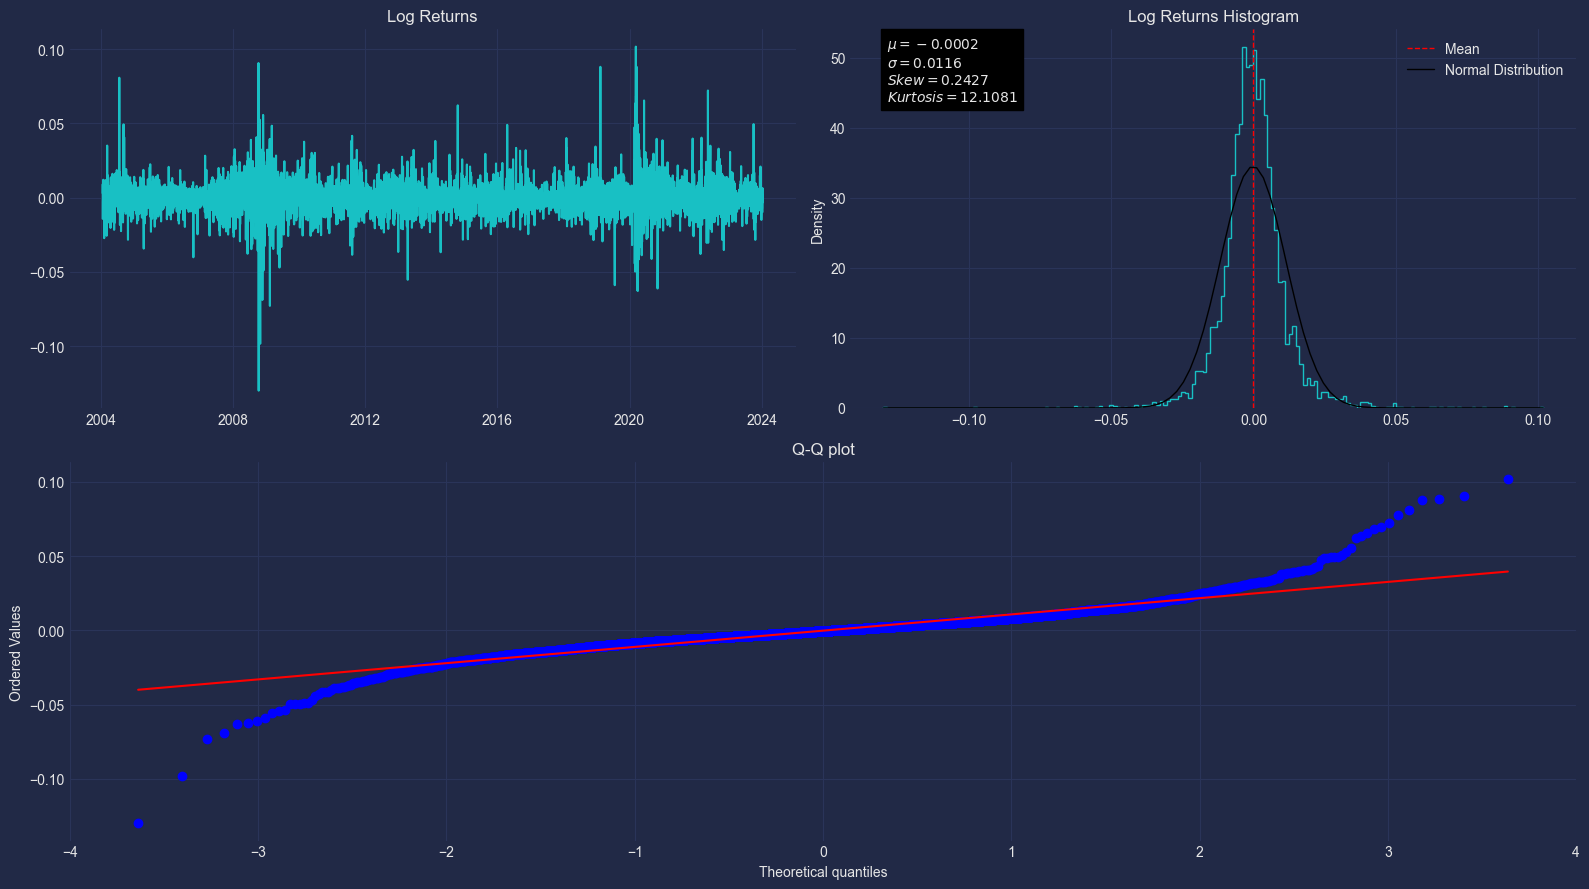

In [6]:
# Calculating the mean and standard deviation of the log returns to plot them on the histogram
mu_stock = stock_1['Log Returns'].mean()
sigma_stock = stock_1['Log Returns'].std()
skewness_stock = skew(stock_1['Log Returns'])
kurt_stock = kurtosis(stock_1['Log Returns'])

textstr1 = '\n'.join((
    r'$\mu=%.4f$' % (mu_stock, ),
    r'$\sigma=%.4f$' % (sigma_stock, ),
    r'$Skew=%.4f$' % (skewness_stock, ),
    r'$Kurtosis=%.4f$' % (kurt_stock, )))

# Create a gridspec object
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Plotting the log returns, log returns histogram, ACF and PACF
fig = plt.figure(figsize=(16, 9))

ax0 = plt.subplot(gs[0])
ax0.plot(stock_1['Log Returns'])
ax0.set_title('Log Returns')

ax1 = plt.subplot(gs[1])
n, bins, patches = ax1.hist(stock_1['Log Returns'], bins=bin_calculator(
    stock_1['Log Returns']), density=True, histtype='step')
ax1.axvline(mu_stock, linestyle='dashed',
            linewidth=1, color='red', label='Mean')
ax1.text(0.05, 0.81, textstr1, transform=ax1.transAxes,
         bbox=dict(facecolor='black', edgecolor='black'))

# Generate the x values for the normal distribution curve
x = np.linspace(min(bins), max(bins), 100)

# Generate the y values for the normal distribution curve
y = norm.pdf(x, mu_stock, sigma_stock)

# Plot the normal distribution curve
ax1.plot(x, y, 'k', linewidth=1, label='Normal Distribution')

ax1.legend()
ax1.set_ylabel('Density')
ax1.set_title('Log Returns Histogram')

# Add a new subplot that spans the whole width of the figure
ax2 = plt.subplot(gs[2:])

# Create a Q-Q plot
probplot(stock_1['Log Returns'].dropna(), dist="norm", plot=ax2)
ax2.set_title('Q-Q plot')

plt.tight_layout()
plt.show()

### Normality Test - Curiousity

In [7]:
# stock_1 to array for normality test
stock_1_array = np.array(stock_1['Log Returns'])
komolgorov_test = stats.kstest(stock_1_array, 'norm', alternative='less')
shapiro_test = stats.shapiro(stock_1_array)
andersont_test = stats.anderson(stock_1_array, dist='norm')

# Create a dictionary with the test results
test_results = {
    'Test': ['Komolgorov', 'Shapiro', 'Anderson'],
    'Statistic': [komolgorov_test[0], shapiro_test[0], andersont_test[0]],
    'P-Value': [komolgorov_test[1], shapiro_test[1], 'N/A'],
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(test_results)

# If you want to include the critical values for the Anderson test
df.loc[df['Test'] == 'Anderson', 'Critical Values'] = str(andersont_test[1])

df

,Test,Statistic,P-Value,Critical Values
0,Komolgorov,0.479954,0.0,nan
1,Shapiro,0.895483,0.0,nan
2,Anderson,82.108655,N/A,[0.576 0.655 0.786 0.917 1.091]


### TEST - Simulating correlated Brownian motions


In [18]:
rho = -0.2
number_of_samples = 1000
mu = np.array([0, 0])
cov = np.array([[1, rho], [rho, 1]])

process = np.random.multivariate_normal(mu, cov, number_of_samples)

np.corrcoef(process.T)

array([[ 1.        , -0.19794745],
       [-0.19794745,  1.        ]])

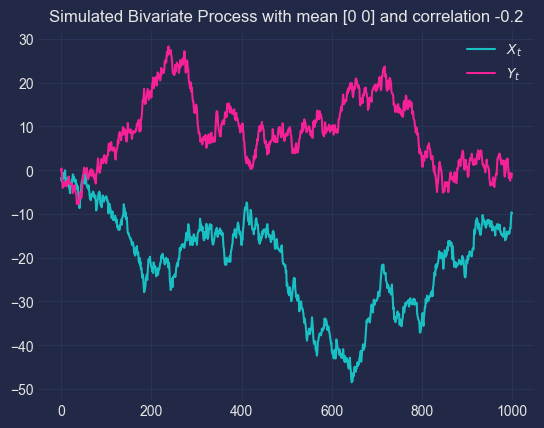

In [22]:
plt.plot(process.cumsum(axis=0))
plt.legend(["$X_t$", "$Y_t$"])
plt.title(f"Simulated Bivariate Process with mean {mu} and correlation {rho}")
plt.show()

## Heston Model - Calibration

Applying the Ito lemma and standard arbitrage arguments we arrive at Garman’s partial differential equation

**$$\frac{\partial C}{\partial t} + \frac{1}{2}vS^2\frac{\partial^2 C}{\partial S^2} + rS\frac{\partial C}{\partial S} - rC + [\kappa(\theta - V) - \lambda V] \frac{\partial C}{\partial V} + \frac{\sigma^2 V}{2} \frac{\partial^2 C}{\partial V^2} + \rho \sigma SV \frac{\partial^2 C}{\partial S \partial V} = 0$$**

Heston builds the solution of the PDE above by the method of characteristic functions. He looks for a solution of the form corresponding to the Black-Scholes model.

**$$C(S_0,K,v_0,\tau) = SP_1 - Ke^{-r(\tau)}P_2$$**

Where:

- $P_1$ is the delta of the European call option
- $P_2$ is the conditional risk neutral probability that the asset price will be greater than K at the maturity

Both $P_1$ and $P_2$ satisfy the PDE above provided that $\varphi_1$ and $\varphi_2$ are known.

The terms $P_1$ and $P_2$ are defined via the inverse Fourier transform:

**$$P_j = \frac{1}{2} + \frac{1}{\pi} \int_{0}^{\infty}Re[\frac{e^{-i\phi ln(K) \varphi_j(S_0,v_0,\tau; \phi)}}{i\phi}]d\phi, \quad j = 1, 2$$**

Heston then assumes that the characteristic function $\varphi_j$ has the form:

**$$\varphi_j(S_0,v_0,\tau; \phi) = e^{C_j(\tau; \phi) + D_j(\tau; \phi)v_0 + i\phi X}$$**

**$$C(\tau; \phi) = r\phi i\tau + \frac{a}{\sigma^2}(b_j - \rho\sigma\phi i + d)\tau -2ln[\frac{1-ge^{d\tau}}{1-g}]$$**

**$$D(\tau; \phi) = \frac{b_j - \rho \sigma \phi i + d}{\sigma^2} [\frac{1- e^{d\tau}}{1- ge^{d\tau}}]$$**

Where:

**$$g = \frac{b_j - \rho \sigma \phi i + d}{b_j - \rho \sigma \phi i - d} $$**

**$$d = \sqrt{(\rho \sigma \phi i - b_j)^2-\sigma^2(2u_j\phi i - \phi^2)}$$**

$u_1 = 0.5$, $u_2 = -0.5$, $b_1 = \kappa + \lambda - \rho \sigma$, $b_2 = \kappa + \lambda$ for $j = 1, 2$

Note:

- Dividend yield $q = 0$ otherwise where there is $r$ we should have $(r - q)$

### Characteristic Function

**$$\varphi_j(S_0,v_0,\tau; \phi) = e^{C_j(\tau; \phi) + D_j(\tau; \phi)v_0 + i\phi X}$$**

**$$\varphi_j(S_0,v_0,\tau; \phi) = e^{r\phi i \tau}S^{i\phi}[\frac{1-ge^{d\tau}}{1- g}]^{\frac{-2a}{\sigma^2}}e^{\frac{a\tau}{\sigma^2}(b_2 - \rho \sigma \phi i +d) + \frac{v_0}{\sigma^2}(b_2 - \rho \sigma \phi i +d)[\frac{1 - e^{d\tau}}{1- ge^{d\tau}}]}$$**

Where:

**$$g = \frac{b_j - \rho \sigma \phi i + d}{b_j - \rho \sigma \phi i - d} $$**

**$$d = \sqrt{(\rho \sigma \phi i - b_j)^2-\sigma^2(2u_j\phi i - \phi^2)}$$**

**$$a = \kappa \theta$$**

**$$b_2 = \kappa + \lambda$$**



In [ ]:
def heston_charfunc(
    phi,
    initial_stock_price,
    initial_variance,
    kappa,
    theta,
    sigma,
    rho,
    lambd,
    tau,
    risk_free_rate,
):
    # constants
    a = kappa * theta
    b = kappa + lambd
    # common terms w.r.t phi
    rspi = rho * sigma * phi * 1j
    # define d parameter given phi and b
    d = np.sqrt((rho * sigma * phi * 1j - b) **
                2 + (phi * 1j + phi**2) * sigma**2)
    # define g parameter given phi, b and d
    g = (b - rspi + d) / (b - rspi - d)
    # calculate characteristic function by components
    exp1 = np.exp(risk_free_rate * phi * 1j * tau)
    term2 = initial_stock_price ** (phi * 1j) * (
        (1 - g * np.exp(d * tau)) / (1 - g)
    ) ** (-2 * a / sigma**2)
    exp2 = np.exp(
        a * tau * (b - rspi + d) / sigma**2
        + initial_variance
        * (b - rspi + d)
        * ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau)))
        / sigma**2
    )
    return exp1 * term2 * exp2

### Integrand Function

**$$\int_{0}^{\infty} Re[e^{r\tau} \frac{\varphi(\phi - i)}{i\phi K^{i\phi}} - K \frac{\varphi(\phi)}{i\phi K^{i\phi}}]d\phi$$**

In [ ]:
# Heston integrand
def integrand(
    phi,
    initial_stock_price,
    strike,
    initial_variance,
    kappa,
    theta,
    sigma,
    rho,
    lambd,
    tau,
    risk_free_rate,
):
    args = (
        initial_stock_price,
        initial_variance,
        kappa,
        theta,
        sigma,
        rho,
        lambd,
        tau,
        risk_free_rate,
    )
    numerator = np.exp(risk_free_rate * tau) * heston_charfunc(
        phi - 1j, *args
    ) - strike * heston_charfunc(phi, *args)
    denominator = 1j * phi * strike ** (1j * phi)
    return numerator / denominator


### Pricing (Rectangular integration & quandature integration)

**$$C(S_0,K,v_0,\tau) = \frac{1}{2} (S_0 - Ke^{-r\tau}) + \frac{1}{\pi} \int_{0}^{\infty} Re[e^{r\tau} \frac{\varphi(\phi - i)}{i\phi K^{i\phi}} - K \frac{\varphi(\phi)}{i\phi K^{i\phi}}] d\phi$$**


In [ ]:
# Heston price using rectangular integration
def heston_price_rec(
    initial_stock_price,
    strike,
    initial_variance,
    kappa,
    theta,
    sigma,
    rho,
    lambd,
    tau,
    risk_free_rate,
):
    args = (
        initial_stock_price,
        initial_variance,
        kappa,
        theta,
        sigma,
        rho,
        lambd,
        tau,
        risk_free_rate,
    )

    P, umax, N = 0, 100, 10000
    dphi = umax / N  # dphi is width

    for i in range(1, N):
        # rectangular integration
        phi = dphi * (2 * i + 1) / 2  # midpoint to calculate height
        numerator = np.exp(risk_free_rate * tau) * heston_charfunc(
            phi - 1j, *args
        ) - strike * heston_charfunc(phi, *args)
        denominator = 1j * phi * strike ** (1j * phi)
        P += dphi * numerator / denominator
    call = np.real(
        (initial_stock_price - strike * np.exp(-risk_free_rate * tau)) / 2 + P / np.pi
    )
    put = call - initial_stock_price + strike * np.exp(-risk_free_rate * tau)
    return [call, put]


# Heston price using quadrature integration
def heston_price(
    initial_stock_price,
    strike,
    initial_variance,
    kappa,
    theta,
    sigma,
    rho,
    lambd,
    tau,
    risk_free_rate,
):
    args = (
        initial_stock_price,
        strike,
        initial_variance,
        kappa,
        theta,
        sigma,
        rho,
        lambd,
        tau,
        risk_free_rate,
    )

    real_integral, err = np.real(quad(integrand, 0, 100, args=args))
    call = (
        initial_stock_price - strike * np.exp(-risk_free_rate * tau)
    ) / 2 + real_integral / np.pi
    put = call - initial_stock_price + strike * np.exp(-risk_free_rate * tau)
    return [call, put, err]

## Heston Model - Calibration

#### Parameter to be calibrated

$\Theta = (\kappa, \theta, \sigma, \rho, V_0, \lambda)$

#### Calibration Scheme

The aim of the calibration is to minimize the least square error between the market prices and the model prices. The calibration is done by minimizing the objective function:

**$$SqErr(\theta) = \sum_{i=1}^{N} \sum_{j=1}^{M} w_{ij}[C_{MP}(X_i, \tau_j) - C_{SV}(S(t), X_i, fwd_j, dfs_j, \tau_j, \theta)]^a + Penalty(\Theta, \Theta_0)$$**

Where:

- $C_{MP}(X_i, \tau_j)$ is the market price of the option with strike $X_i$ and maturity $\tau_j$
- $C_{SV}(S(t), X_i, fwd_j, dfs_j, \tau_j, \theta)$ is the model price of the option with strike $X_i$ and maturity $\tau_j$
- $fwd$ is the forward price
- $dfs$ is the discount factor

Note:

In our case we took 0 as the penalty, however, the penalty function may be the distance between the calibrated parameters and the initial parameters. $Penalty(\Theta, \Theta_0) = || \Theta - \Theta_0 ||^2$

For my implementation, see the files `heston_modeling.py and heston_calibration_test.py`

## Heston Model - Monte Carlo Simulation

In [40]:
def heston_volatility_process(
    steps, number_of_samples, kappa, theta, xi, rho, v0, T, r, s0, return_vol=False, scheme='full truncation'
):
    dt = T / steps
    size = (number_of_samples, steps)
    prices = np.zeros(size)
    v = np.zeros(size)
    s_t = s0
    v_t = v0
    for i in range(steps):
        Z = np.random.multivariate_normal(
            np.array([0, 0]), cov=np.array([[1, rho], [rho, 1]]), size=number_of_samples
        )
        s_t = s_t * (np.exp((r - 0.5 * v_t) * dt +
                     np.sqrt(v_t * dt) * Z[:, 0]))
        if scheme == 'full truncation':
            v_t = np.maximum(v_t + kappa * (theta - v_t) *
                             dt + xi * np.sqrt(v_t * dt) * Z[:, 1], 0)
        elif scheme == 'reflection':
            v_t = np.abs(v_t + kappa * (theta - v_t) * dt +
                         xi * np.sqrt(v_t * dt) * Z[:, 1])
        else:
            raise ValueError('scheme must be either "full truncation" or "reflection"')

        v[:, i] = v_t
        prices[:, i] = s_t

    if return_vol:
        return prices, v
    return prices

### Parameters

In [45]:
steps = 252
number_of_samples = 1000
kappa = 1.214 # mean reversion factor
theta = 0.249 # long run average variance of price
xi = 0.182 # volatility of volatility
rho = -0.8 # correlation between the two brownian motions
v0 = 0.213 # initial volatility
T = 1 # time horizon
r = 0.05 # risk free rate
s0 = 100 # initial stock price

In [46]:
test = heston_volatility_process(
    steps, number_of_samples, kappa, theta, xi, rho, v0, T, r, s0, return_vol=True, scheme='full truncation'
)

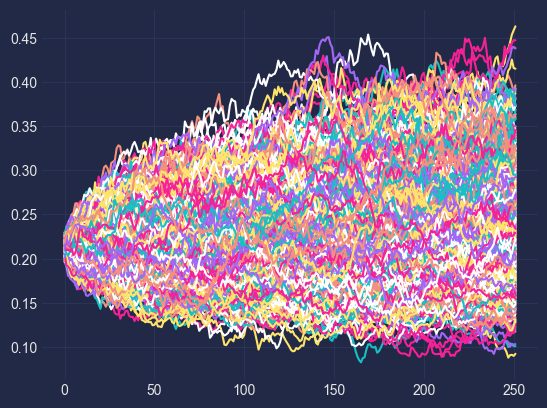

In [47]:
plt.plot(test[1].T)
plt.show()

In [13]:
test[1][:, 43].mean()

0.22038615841153472